# CTM MILP Formulation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from pprint import pprint
import time

from ctmmodels.const import *
from ctmmodels.nophasing import Constraint5Model

## Constants

In [2]:
FLOW_UNDERSAT       = 450 # veh / hr / lane
FLOW_SAT            = 600 
FLOW_OVERSAT        = 900

Timesteps : Running Time
10        : 0.32
20        : 7.18

## Using the Module

In [3]:
model = Constraint5Model(time_step=1, time_range=60, g_min=6, g_max=20)
model.generate()

In [4]:
model._constraints.keys()

['turnratios', 'greentime', 'init', 'flowcon', 'flowrate', 'greenflowrate']

In [5]:
model.solve()

Solving...

KeyboardInterrupt
Done!
Time elapsed: 295.488022089


295.4880220890045

## Showing the Cell Capacities

In [16]:
df_x, df_y, df_g = model.return_solution()

In [17]:
df_x_source = df_x[df_x.cell == (CELL_SOURCE,0,1)].sort_values(by='timestep')
df_x_normal0 = df_x[df_x.cell == (CELL_NORMAL,0,1)].sort_values(by='timestep')
df_x_normal1 = df_x[df_x.cell == (CELL_NORMAL,1,1)].sort_values(by='timestep')
df_x_normal2 = df_x[df_x.cell == (CELL_NORMAL,2,1)].sort_values(by='timestep')
df_x_left = df_x[df_x.cell == (CELL_MOVEMENT,THROUGH_TURN,1)].sort_values(by='timestep')
df_x_sink = df_x[df_x.cell == model.S[(CELL_MOVEMENT,THROUGH_TURN,1)][0]].sort_values(by='timestep')

df_x_approach = df_x_source.append(df_x_normal1).append(df_x_normal2).append(df_x_normal0).append(df_x_left).append(df_x_sink)
df_x_approach = df_x_approach.pivot(index='timestep', columns='cell', values='volume')
df_x_approach

cell,"(0, 0, 1)","(1, 0, 3)","(2, 1, 1)","(3, 0, 1)","(3, 1, 1)","(3, 2, 1)"
timestep,,,,,,
0,0.666667,0.000000,0.000000e+00,0.000000,0.000000,0.000000
1,0.666667,0.000000,0.000000e+00,0.666667,0.000000,0.000000
2,0.666667,0.000000,0.000000e+00,0.666667,0.666667,0.000000
3,0.666667,0.000000,0.000000e+00,0.666667,0.666667,0.666667
4,0.666667,0.000000,5.333333e-01,0.666667,0.666667,0.666667
5,0.666667,0.666667,5.333333e-01,0.666667,0.666667,0.666667
6,0.666667,0.666667,5.333333e-01,0.666667,0.666667,0.666667
7,0.666667,0.000000,1.066667e+00,0.666667,0.666667,0.666667
8,0.666667,1.333333,5.333333e-01,0.666667,0.666667,0.666667


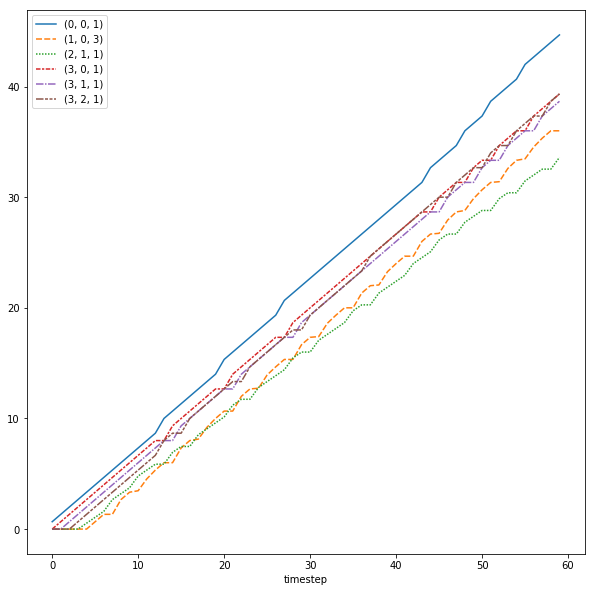

In [18]:
_, ax = plt.subplots(figsize=(10,10))
sns.lineplot(data=df_x_approach.cumsum())

This linear, cascading cumulative sum of consecutive cells (except for the through cell) means that the turning ratio is working fine.

In [19]:
df_y_source = df_y[df_y.cell_from == (CELL_SOURCE,0,1)].groupby(['cell_from', 'timestep']).agg({'flow': 'sum'}).sort_values(by='timestep')
df_y_normal0 = df_y[df_y.cell_from == (CELL_NORMAL,0,1)].groupby(['cell_from', 'timestep']).agg({'flow': 'sum'}).sort_values(by='timestep')
df_y_normal1 = df_y[df_y.cell_from == (CELL_NORMAL,1,1)].groupby(['cell_from', 'timestep']).agg({'flow': 'sum'}).sort_values(by='timestep')
df_y_normal2 = df_y[df_y.cell_from == (CELL_NORMAL,2,1)].groupby(['cell_from', 'timestep']).agg({'flow': 'sum'}).sort_values(by='timestep')
df_y_normal2 = df_y[df_y.cell_from == (CELL_NORMAL,2,1)].groupby(['cell_from', 'timestep']).agg({'flow': 'sum'}).sort_values(by='timestep')
df_y_left = df_y[df_y.cell_from == (CELL_MOVEMENT,THROUGH_TURN,1)].groupby(['cell_from', 'timestep']).agg({'flow': 'sum'}).sort_values(by='timestep')
df_y_sink = df_y[df_y.cell_from == model.S[(CELL_MOVEMENT,THROUGH_TURN,1)][0]].groupby(['cell_from', 'timestep']).agg({'flow': 'sum'}).sort_values(by='timestep')

df_y_approach = df_y_source.append(df_y_normal1).append(df_y_normal2).append(df_y_normal0).append(df_y_left).append(df_y_sink)
df_y_approach.reset_index(inplace=True)
df_y_approach = df_y_approach.pivot(index='timestep', columns='cell_from', values='flow')
df_y_approach

cell_from,"(0, 0, 1)","(2, 1, 1)","(3, 0, 1)","(3, 1, 1)","(3, 2, 1)"
timestep,,,,,
0,0.666667,0.000000,0.000000,0.000000,0.000000e+00
1,0.666667,0.000000,0.666667,0.000000,0.000000e+00
2,0.666667,0.000000,0.666667,0.666667,0.000000e+00
3,0.666667,0.000000,0.666667,0.666667,6.666667e-01
4,0.666667,0.533333,0.666667,0.666667,6.666667e-01
5,0.666667,0.533333,0.666667,0.666667,6.666667e-01
6,0.666667,0.000000,0.666667,0.666667,6.666667e-01
7,0.666667,1.066667,0.666667,0.666667,6.666667e-01
8,0.666667,0.533333,0.666667,0.666667,6.666667e-01


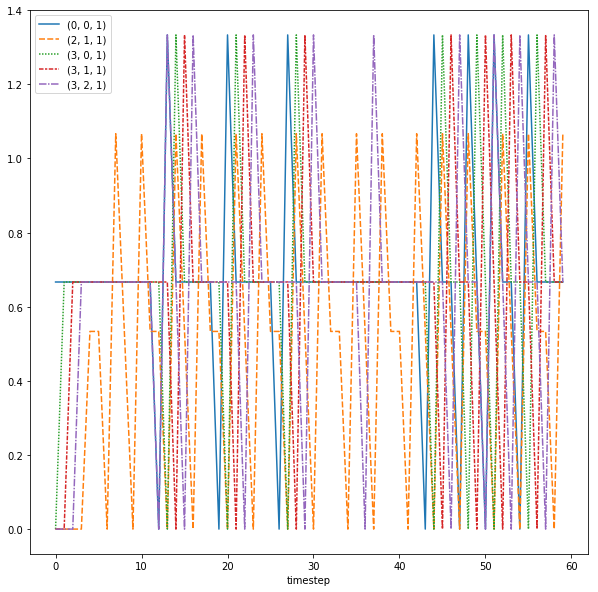

In [20]:
_, ax = plt.subplots(figsize=(10,10))
sns.lineplot(data=df_y_approach)

### Comparing the Green Signal and the Flow

In [21]:
df_g_specific = df_g[df_g.cell == (CELL_MOVEMENT,THROUGH_TURN,1)].sort_values(by='timestep')
df_y_specific = df_y[(df_y.cell_from == (CELL_MOVEMENT,THROUGH_TURN,1)) & (df_y.cell_to == model.S[(CELL_MOVEMENT,THROUGH_TURN,1)][0])].sort_values(by='timestep')
df_y_specific = df_y_specific.groupby(['timestep', 'cell_from']).agg({'flow': 'sum'}).reset_index()

df_g_y = pd.merge(df_g_specific, df_y_specific, left_on=['timestep', 'cell'], right_on=['timestep', 'cell_from'])[
    ['timestep', 'is_green', 'flow']
]

df_g_y.set_index('timestep', inplace=True)

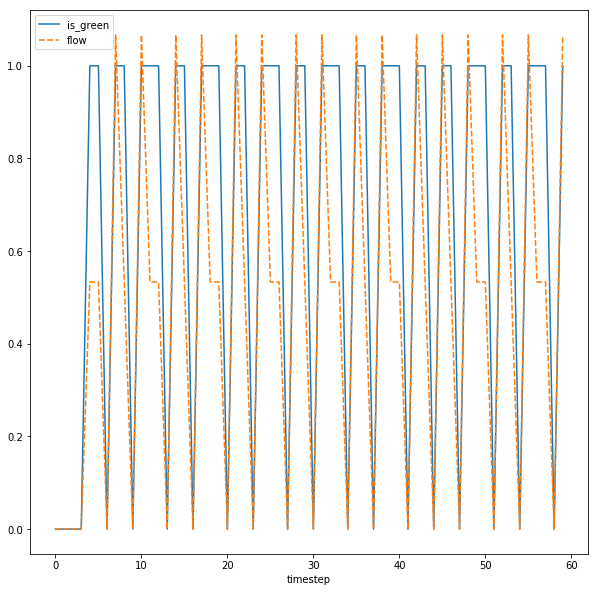

In [22]:
_, ax = plt.subplots(figsize=(10,10))
sns.lineplot(data=df_g_y)